In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as pt
import seaborn as sns
import pandas as pd
from spn.structure.Base import Sum, Product, Context, get_nodes_by_type, get_topological_order_layers, get_number_of_nodes
from spn.structure.leaves.parametric.Parametric import Gaussian, Categorical
from spn.algorithms.LearningWrappers import learn_mspn, learn_classifier, learn_parametric
from sklearn.datasets import make_classification
from spn.algorithms.MPE import mpe
from spn.algorithms.EM import EM_optimization
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.Sampling import sample_instances
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from itertools import combinations, product
from scipy.special import softmax
from utils import random_region_graph, region_graph_to_spn, reassign_node_ids
import warnings
warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

In [3]:
def map_scopes(spn, inds):
    nodes = get_nodes_by_type(spn)
    scope_mapping = {i: s for i, s in enumerate(inds)}
    for n in nodes:
        sc = list(n.scope)
        new_sc = [scope_mapping[i] for i in sc]
        n.scope = new_sc
    return spn

def reassign_ids(spn):
    nodes = get_nodes_by_type(spn)
    for i, n in enumerate(nodes):
        n.id = i
    return spn

def make_dataset(num_samples, num_features, n_informative, n_redundant, n_classes, n_clusters, n_repeated):
    x, y = make_classification(num_samples, num_features, n_informative=n_informative, 
                               n_redundant=n_redundant, n_classes=n_classes, n_clusters_per_class=n_clusters,
                               n_repeated=n_repeated, class_sep=2)
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)
    train_data = np.hstack([train_x, train_y.reshape(-1, 1)])
    test_data = np.hstack([test_x, test_y.reshape(-1, 1)])
    return train_data, test_data

In [4]:
num_features = 20
datasets = {}
for num_corrs in [0, 10, 15]:
    inf = num_features - num_corrs
    train, test = make_dataset(2000, num_features, inf, num_corrs, 2, 1, 0)
    datasets[num_corrs] = (train, test)

In [4]:
def vertical_fl_indep_assumption(n_clients):
    accs = []
    stds = []
    for r in [0, 10, 15]:
        print(f"Train with r={r} redundant features")
        train_data, test_data = datasets[r]
        train_data = np.copy(train_data)
        test_data = np.copy(test_data)
        y = np.copy(test_data[:, -1])
        test_data[:, -1] = np.nan
        # split data on n clients vertically
        indices = np.arange(train_data.shape[1])
        s = np.array_split(indices, n_clients)
        class_idx = train_data.shape[1] - 1
        exp_accs = []
        for _ in range(5):
            # train one spn on each client
            spns = []
            for cl_idx in s:
                client_data = train_data[:, cl_idx]
                client_features = client_data.shape[1] - 1
                if class_idx in cl_idx:
                    context = Context(parametric_types=[Gaussian]*client_features + [Categorical]).add_domains(client_data)
                else:
                    context = Context(parametric_types=[Gaussian]*(client_features + 1)).add_domains(client_data)
                spn_classification = learn_mspn(client_data, context)
                spn_classification = map_scopes(spn_classification, cl_idx)
                spns.append(spn_classification)
            
            spn = Product(children=spns)
            spn.scope = list(set().union(*[set(n.scope) for n in spns]))
            spn = reassign_ids(spn)
            # evaluate server model
            pred = mpe(spn, test_data)
            pred = pred[:, -1]
            acc = sum(y == pred) / len(y)
            exp_accs.append(acc)
        print(f"Mean Accuracy: {np.mean(exp_accs)}")
        accs.append(np.mean(exp_accs))
        stds.append(np.std(exp_accs))
    return accs, stds

In [123]:
num_clients = [2, 3, 4, 5]
accs_fl_indep = []
stds_fl_indep = []
for c in num_clients:
    accuracies, stds = vertical_fl_indep_assumption(c)
    accs_fl_indep.append(accuracies)
    stds_fl_indep.append(stds)

Train with r=0 redundant features


Mean Accuracy: 0.8966666666666667
Train with r=15 redundant features
Mean Accuracy: 0.8566666666666667


In [6]:
coor_features = [0, 10, 15]
res = []
for n, acc, std in zip(num_clients, accs_fl_indep, stds_fl_indep):
    nc = [n]*len(acc)
    res.append(np.vstack([nc, acc, std, coor_features]).T)
res = np.vstack(res)
df = pd.DataFrame(data=res, columns=['Clients', 'Accuracy', 'Std', 'Corr'])
df.to_csv('hallucinating_classification_exp.csv')

NameError: name 'num_clients' is not defined

In [5]:
from scipy.special import logsumexp

from spn.algorithms.Gradient import gradient_backward
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.Validity import is_valid

from spn.structure.Base import Sum, get_nodes_by_type, get_number_of_nodes
import numpy as np
from copy import deepcopy

def softmax(vec, temperature):
    """
    turn vec into normalized probability
    """
    sum_exp = sum(np.exp(x/temperature) for x in vec)
    return np.array([np.exp(x/temperature)/sum_exp for x in vec])

def cond_sum_em_update(allowed_nodes):
    def sum_em_update(node, node_gradients=None, root_lls=None, all_lls=None, **kwargs):
        if node.id in allowed_nodes:
            RinvGrad = node_gradients - root_lls

            for i, c in enumerate(node.children):
                new_w = RinvGrad + (all_lls[:, c.id] + np.log(node.weights[i]))
                node.weights[i] = logsumexp(new_w)

            assert not np.any(np.isnan(node.weights))

            node.weights = np.exp(node.weights - logsumexp(node.weights)) + np.exp(-100)

            node.weights = node.weights / node.weights.sum()
            #node.weights = softmax(node.weights, 0.1)
            idx = np.argsort(node.weights)[:-3]
            node.weights[idx] = 0
            node.weights = node.weights / node.weights.sum()


            if node.weights.sum() > 1:
                node.weights[np.argmax(node.weights)] -= node.weights.sum() - 1

            assert not np.any(np.isnan(node.weights))
            assert np.isclose(np.sum(node.weights), 1)
            assert not np.any(node.weights < 0)
            assert node.weights.sum() <= 1, "sum: {}, node weights: {}".format(node.weights.sum(), node.weights)
    return sum_em_update

_node_updates = {Sum: cond_sum_em_update([0])}

def add_node_em_update(node_type, lambda_func):
    _node_updates[node_type] = lambda_func


def EM_optimization_network(spn, data, iterations=5, node_updates=_node_updates, skip_validation=False, **kwargs):
    if not skip_validation:
        valid, err = is_valid(spn)
        assert valid, "invalid spn: " + err

    lls_per_node = np.zeros((data.shape[0], get_number_of_nodes(spn)))

    for _ in range(iterations):
        # one pass bottom up evaluating the likelihoods
        log_likelihood(spn, data, dtype=data.dtype, lls_matrix=lls_per_node)

        gradients = gradient_backward(spn, lls_per_node)

        R = lls_per_node[:, 0]

        for node_type, func in node_updates.items():
            for node in get_nodes_by_type(spn, node_type):
                func(
                    node,
                    node_lls=lls_per_node[:, node.id],
                    node_gradients=gradients[:, node.id],
                    root_lls=R,
                    all_lls=lls_per_node,
                    all_gradients=gradients,
                    data=data,
                    **kwargs
                )

In [6]:
def build_fedspn_head(client_cluster_spns):
    num_clients = len(client_cluster_spns)
    # assume num clusters is equal on all clients 
    num_clusters = len(client_cluster_spns[0])
    clusters = list(range(num_clusters))
    prods = {}
    for l in range(1, num_clients):
        for comb in product(*[clusters]*num_clients):
            prefix = list(comb)[:l]
            next_node = list(comb)[l]
            prod_id = tuple(prefix + [next_node])
            if l > 1:
                # connect product node of last layer with next_node's SPN of l-the client
                relevant_spns = [prods[tuple(prefix)], client_cluster_spns[l][next_node]]
            else:
                # first product layer -> connect all client SPNs of a certain prod_id
                relevant_spns = [client_cluster_spns[i][j] for i,j in enumerate(prod_id)]
            scopes = [set(s.scope) for s in relevant_spns]
            prod_scope = list(set().union(*scopes))
            prod = Product(relevant_spns)
            prod.scope = prod_scope
            prods[prod_id] = prod

    all_scopes = set()
    for cluster_spns in client_cluster_spns:
        for s in cluster_spns:
            all_scopes = all_scopes.union(set(s.scope))
    
    root_children = [n for prefix, n in prods.items() if len(prefix) == num_clients]
    weights = softmax(np.zeros(len(root_children)), 1)
    #weights = softmax(np.random.normal(0, 0.5, len(root_children)))
    root = Sum(weights, root_children)
    root.scope = list(all_scopes)
    root = reassign_node_ids(root)
    return root

In [7]:

def vertical_fl(n_clients):
    accs = []
    stds = []
    for r in [0, 10, 15]:
        print(f"Train with r={r} redundant features")
        train_data, test_data = datasets[r]
        train_data = np.copy(train_data)
        test_data = np.copy(test_data)
        y = np.copy(test_data[:, -1])
        test_data[:, -1] = np.nan
        # split data on n clients vertically
        indices = np.arange(train_data.shape[1])
        s = np.array_split(indices, n_clients)
        class_idx = train_data.shape[1] - 1
        exp_accs = []
        for _ in range(5):
            # train one spn on each client
            spns = []
            for cl_idx in s:
                client_data = train_data[:, cl_idx]
                client_features = client_data.shape[1] - 1
                kmeans = KMeans(2)
                if class_idx in cl_idx:
                    context = Context(parametric_types=[Gaussian]*client_features + [Categorical]).add_domains(client_data)
                    clusters = kmeans.fit_predict(client_data)
                else:
                    context = Context(parametric_types=[Gaussian]*(client_features + 1)).add_domains(client_data)
                    clusters = kmeans.fit_predict(client_data[:, :-1])
                cluster_spns = []
                for c in np.unique(clusters):
                    idx = np.argwhere(clusters == c).flatten()
                    subset = client_data[idx]
                    spn_classification = learn_mspn(subset, context)
                    spn_classification = map_scopes(spn_classification, cl_idx)
                    cluster_spns.append(spn_classification)
                spns.append(cluster_spns)
            
            spn = build_fedspn_head(spns)

            # optimize server SPN
            # NOTE: It's legal to put client data in here since we can propagate likelihoods
            #   over the network without sending private information
            EM_optimization_network(spn, train_data)
            #print(spn.weights)

            # evaluate server model
            pred = mpe(spn, test_data)
            pred = pred[:, -1]
            acc = sum(y == pred) / len(y)
            exp_accs.append(acc)
        print(f"Mean Accuracy: {np.mean(exp_accs)}")
        accs.append(np.mean(exp_accs))
        stds.append(np.std(exp_accs))
    return accs, stds

In [133]:
num_clients = [2, 3, 4, 5]
accs_fl_dep = []
stds_fl_dep = []
for c in num_clients:
    accuracies, stds = vertical_fl(c)
    accs_fl_dep.append(accuracies)
    stds_fl_dep.append(stds)

Train with r=10 redundant features
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.39633772 0.
 0.         0.         0.1605448  0.         0.         0.
 0.         0.         0.         0.44311748 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.16127928 0.         0.         0.
 0.39598157 0.         0.         0.         0.         0.
 0.         0.44273915 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.16078469 0.         0.
 0.         0.39566548 0.         0.         0.         0.
 0.44354983 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.     

In [77]:
res = []
coor_features = [0, 10, 15]
for i, (n, acc, std) in enumerate(zip(num_clients, accs_fl_dep, stds_fl_dep)):
    nc = [n]*len(acc)
    res.append(np.vstack([nc, acc, std, coor_features]).T)
res = np.vstack(res)
df = pd.DataFrame(data=res, columns=['Clients', 'Accuracy', 'Std', 'Corr'])
df.to_csv('non-hallucinating_classification_exp.csv')

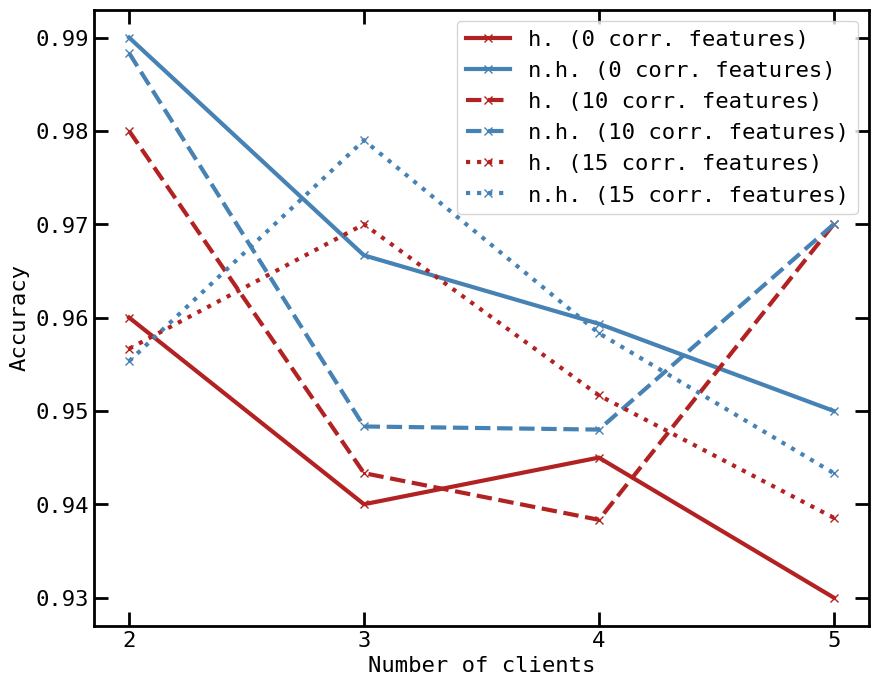

In [139]:
df_hallu = pd.read_csv('./hallucinating_classification_exp.csv', index_col=0)
df_nhalu = pd.read_csv('./non-hallucinating_classification_exp.csv', index_col=0)
fig, ax = plt.subplots(figsize=(10, 8))
for nc in np.unique(df_hallu['Corr'].to_numpy()):
    hallu_sub = df_hallu[df_hallu['Corr'] == nc]
    nhallu_sub = df_nhalu[df_nhalu['Corr'] == nc]
    if nc == 0:
        ls = 'solid'
    elif nc == 10:
        ls = 'dashed'
    elif nc == 15:
        ls = 'dotted'
    plt.plot(np.arange(len(hallu_sub)), hallu_sub['Accuracy'], label=f'h. ({int(nc)} corr. features)', marker='x', linestyle=ls, c='firebrick', linewidth=3.)
    plt.plot(np.arange(len(hallu_sub)), nhallu_sub['Accuracy'], label=f'n.h. ({int(nc)} corr. features)', marker='x', linestyle=ls, c='steelblue', linewidth=3.)
ax.tick_params(which='major', size=10, width=2, direction='in', right='on', top='on')
ax.tick_params(which='minor', size=7, width=2, direction='in', right='on', top='on')
plt.xlabel('Number of clients')
plt.ylabel('Accuracy')
plt.xticks(np.arange(4), np.array([2, 3, 4, 5]))
plt.legend()
plt.savefig('halucinating_fedspn_classification.pdf')
plt.show()


- replace MNIST by SVHN, Celeba or something
- Normalizing Flow in Leaves?

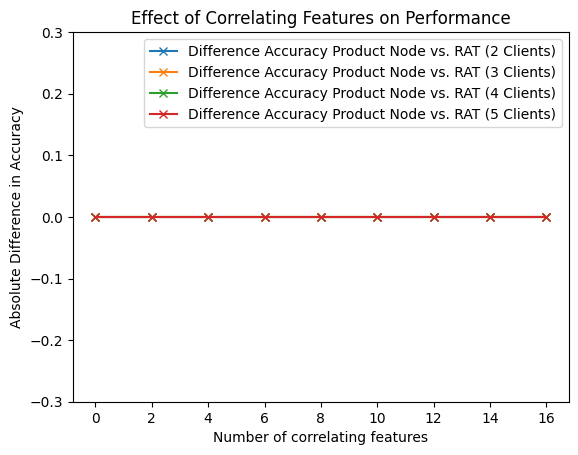

In [15]:
fig = plt.figure()
for ix, c in enumerate(num_clients):
    prod, rat = np.array(accs_fl_indep[ix]), np.array(accs_fl_dep[ix])
    diff = prod - rat
    plt.plot(np.arange(len(rat)), diff, label=f'Difference Accuracy Product Node vs. RAT ({c} Clients)', marker='x')
plt.xticks(np.arange(len(prod)), np.arange(0, len(prod)*2, 2))
plt.xlabel('Number of correlating features')
plt.ylabel('Absolute Difference in Accuracy')
plt.ylim([-0.3, 0.3])
plt.title('Effect of Correlating Features on Performance')
plt.legend()
plt.show()

In [16]:
accs_fl_dep

[[0.8133333333333334,
  0.7916666666666666,
  0.595,
  0.7283333333333334,
  0.705,
  0.855,
  0.84,
  0.8166666666666668,
  0.8216666666666667],
 [0.7983333333333333,
  0.7816666666666666,
  0.6766666666666666,
  0.7133333333333334,
  0.8083333333333332,
  0.835,
  0.8116666666666666,
  0.84,
  0.7933333333333333],
 [0.7183333333333334,
  0.7616666666666667,
  0.6966666666666667,
  0.8066666666666666,
  0.7716666666666666,
  0.9,
  0.785,
  0.86,
  0.7883333333333334],
 [0.67,
  0.745,
  0.6416666666666667,
  0.7166666666666667,
  0.6750000000000002,
  0.8733333333333334,
  0.7600000000000001,
  0.8266666666666667,
  0.805]]

In [17]:
accs_fl_indep

[[0.8133333333333332,
  0.7916666666666667,
  0.595,
  0.7283333333333334,
  0.705,
  0.8550000000000001,
  0.8400000000000001,
  0.8166666666666667,
  0.8216666666666667],
 [0.7983333333333335,
  0.7816666666666665,
  0.6766666666666666,
  0.7133333333333333,
  0.8083333333333333,
  0.835,
  0.8116666666666668,
  0.8400000000000001,
  0.7933333333333332],
 [0.7183333333333335,
  0.7616666666666667,
  0.6966666666666665,
  0.8066666666666666,
  0.7716666666666666,
  0.9,
  0.785,
  0.86,
  0.7883333333333333],
 [0.67,
  0.745,
  0.6416666666666667,
  0.7166666666666667,
  0.675,
  0.8733333333333333,
  0.76,
  0.8266666666666665,
  0.805]]

In [137]:
mu_cluster1 = [-1, -1]
mu_cluster2 = [1, 1]
std = 0.5
cluster1, cluster2 = np.random.normal(-1, std, (1000, 2)), np.random.normal(1, std, (1000, 2))
labels = np.array(([0]*1000) + ([1]*1000))
data = np.concatenate([cluster1, cluster2])
data = np.column_stack([data, labels])
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=True)

In [138]:
client_1_data = train_data[:, 0].reshape((train_data.shape[0], 1))
client_2_data = train_data[:, 1:]

# build SPNs
leafs_client_1 = [Gaussian(mu_cluster1[0], std, [0]), Gaussian(mu_cluster2[0], std, [0])]
spn_client_1 = Sum([0.5, 0.5], leafs_client_1)
spn_client_1.scope = [0]

prod_client_2_1 = Product([Gaussian(mu_cluster1[1], std, [0]), Categorical([1, 0.], [1])])
prod_client_2_1.scope = [0, 1]
prod_client_2_2 = Product([Gaussian(mu_cluster2[1], std, [0]), Categorical([0., 1.], [1])])
prod_client_2_2.scope = [0, 1]
spn_client_2 = Sum([0.5, 0.5], [prod_client_2_1, prod_client_2_2])
spn_client_2.scope = [0, 1]

spn_client_1 = reassign_node_ids(spn_client_1)
spn_client_2 = reassign_node_ids(spn_client_2)

In [139]:
spn_client_2 = map_scopes(spn_client_2, [1, 2])
fed_spn = Product([spn_client_1, spn_client_2])
fed_spn.scope = [0, 1, 2]
fed_spn = reassign_node_ids(fed_spn)

In [140]:
test_data_copy = np.copy(test_data)
test_data_copy[:, -1] = np.nan
pred = mpe(fed_spn, test_data_copy)

In [141]:
y = test_data[:, -1]
pred = pred[:, -1]
sum(y == pred) / len(y)

0.9733333333333334

In [142]:
cond = np.array([np.nan, np.nan, np.nan]*1000).reshape(1000, -1)
samples = sample_instances(fed_spn, cond, np.random.RandomState(123))

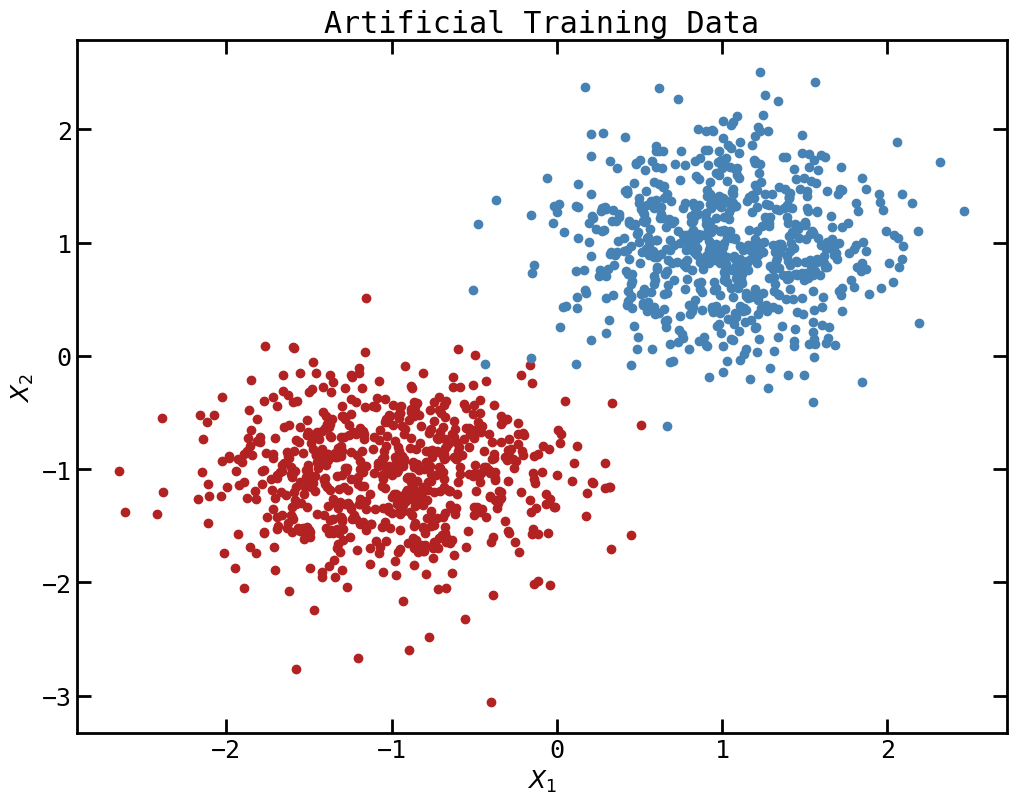

In [143]:
fig, ax = plt.subplots(figsize=(12, 9))
cluster_1_data = train_data[train_data[:, -1] == 0]
cluster_2_data = train_data[train_data[:, -1] == 1]
scluster_1_data = samples[samples[:, -1] == 0]
scluster_2_data = samples[samples[:, -1] == 1]

ax.tick_params(which='major', size=10, width=2, direction='in', right='on', top='on')
ax.tick_params(which='minor', size=7, width=2, direction='in', right='on', top='on')
plt.scatter(cluster_1_data[:, 0], cluster_1_data[:, 1], c='firebrick', label='$y=1$')
plt.scatter(cluster_2_data[:, 0], cluster_2_data[:, 1], c='steelblue', label='$y=2$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
#plt.legend()
plt.title('Artificial Training Data')
plt.savefig('training_data.pdf')
plt.show()

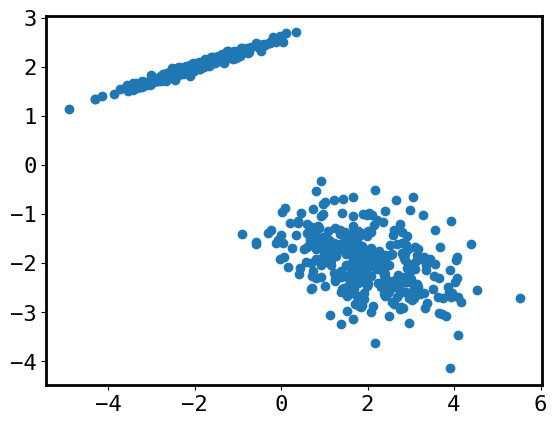

In [151]:
d, _ = make_dataset(1000, 2, 2, 0, 2, 1, 0)
plt.scatter(d[:, 0], d[:, 1])
plt.show()
# TODO: investigate how FedSPN behaves

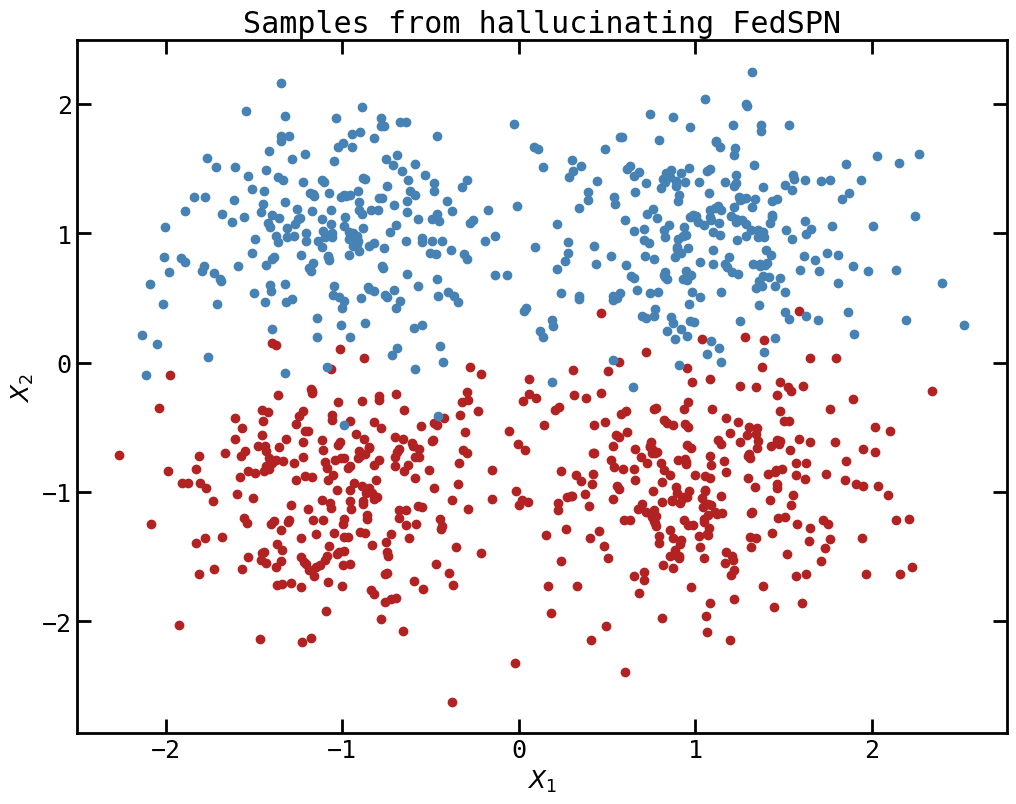

In [144]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.tick_params(which='major', size=10, width=2, direction='in', right='on', top='on')
ax.tick_params(which='minor', size=7, width=2, direction='in', right='on', top='on')
plt.scatter(scluster_1_data[:, 0], scluster_1_data[:, 1], c='firebrick', label='$y=1$')
plt.scatter(scluster_2_data[:, 0], scluster_2_data[:, 1], c='steelblue', label='$y=2$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
#plt.legend()
plt.title('Samples from hallucinating FedSPN')
plt.savefig('hal_fedspn.pdf')
plt.show()

In [133]:
# build SPNs without halluzination
leafs_client_1 = [Gaussian(mu_cluster1[0], std, [0]), Gaussian(mu_cluster2[0], std, [0])]
leafs_client_2 = [Gaussian(mu_cluster1[1], std, [1]), Gaussian(mu_cluster2[1], std, [1]), Categorical([1., 0], [2]), Categorical([0., 1.], [2])]

fed_prod_1 = Product([leafs_client_1[0], leafs_client_2[0], leafs_client_2[2]])
fed_prod_1.scope = [0, 1, 2]
fed_prod_2 = Product([leafs_client_1[1], leafs_client_2[1], leafs_client_2[3]])
fed_prod_2.scope = [0, 1, 2]
fed_spn = Sum([0.5, 0.5], [fed_prod_1, fed_prod_2])
fed_spn.scope = [0, 1, 2]
fed_spn = reassign_node_ids(fed_spn)

In [134]:
test_data_copy = np.copy(test_data)
test_data_copy[:, -1] = np.nan
pred = mpe(fed_spn, test_data_copy)
y = test_data[:, -1]
pred = pred[:, -1]
sum(y == pred) / len(y)

1.0

In [135]:
cond = np.array([np.nan, np.nan, np.nan]*1000).reshape(1000, -1)
samples = sample_instances(fed_spn, cond, np.random.RandomState(123))

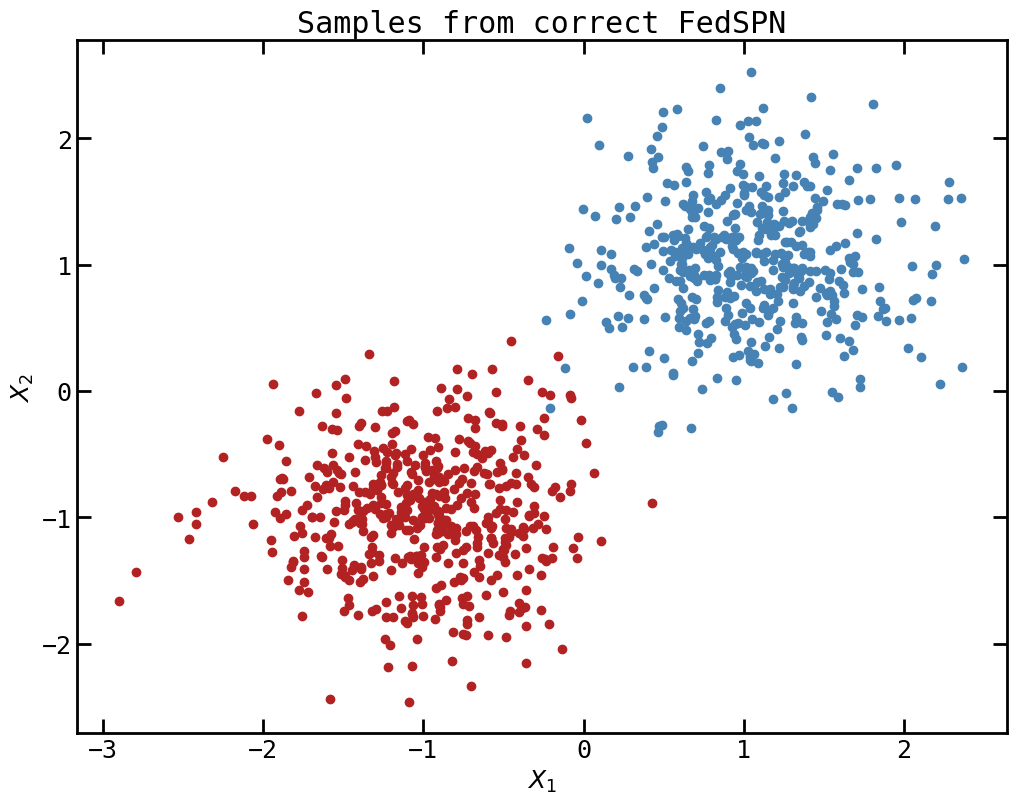

In [136]:
scluster_1_data = samples[samples[:, -1] == 0]
scluster_2_data = samples[samples[:, -1] == 1]
fig, ax = plt.subplots(figsize=(12, 9))
ax.tick_params(which='major', size=10, width=2, direction='in', right='on', top='on')
ax.tick_params(which='minor', size=7, width=2, direction='in', right='on', top='on')
plt.scatter(scluster_1_data[:, 0], scluster_1_data[:, 1], c='firebrick', label='$y=1$')
plt.scatter(scluster_2_data[:, 0], scluster_2_data[:, 1], c='steelblue', label='$y=2$')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
#plt.legend()
plt.title('Samples from correct FedSPN')
plt.savefig('corr_fedspn.pdf')
plt.show()